## import & load

In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')

In [3]:
import data.read
importlib.reload(data.read)
import data.okx.read
importlib.reload(data.okx.read)

<module 'data.okx.read' from '/home/junlim/projects/jitter_recovery/data/okx/read.py'>

In [4]:
#df = data.okx.read.df_okx_20231201_1231.dropna()
df = data.okx.read.df_okx_20240101_0131.dropna()
#df = data.okx.read.df_okx_20240301_0303.dropna()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])
all_symbols = df.symbol.unique()

In [5]:
df.head(2)

,timestamp,symbol,open,high,low,close,volume
0,2024-01-01 05:00:00,TURBO-USDT-SWAP,0.000352,0.000352,0.000352,0.000352,500000.0
1,2024-01-01 05:00:00,LOOKS-USDT-SWAP,0.076400,0.076400,0.076300,0.076400,3323.0


In [6]:
df.tail(2)

,timestamp,symbol,open,high,low,close,volume
4060709,2024-01-31 04:58:00,BTC-USD-SWAP,42960.8000,42960.9000,42951.9000,42954.7000,3.8149
4060710,2024-01-31 04:58:00,CFX-USDT-SWAP,0.2263,0.2263,0.2259,0.2261,140070.0000


In [7]:
all_symbols = [s for s in all_symbols if s]

In [8]:
len([s for s in all_symbols if 'USDT' in s])

163

## multiple symbols

In [16]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [10]:
feature_param = algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(30)

In [11]:
dfst_feature = algo.jitter_recovery.research.get_dfst_feature(df, feature_param)

0 symbol: TURBO-USDT-SWAP (feature)
1 symbol: LOOKS-USDT-SWAP (feature)
2 symbol: IOST-USDT-SWAP (feature)
3 symbol: TRX-USDT-SWAP (feature)
4 symbol: PEPE-USDT-SWAP (feature)
5 symbol: BLUR-USDT-SWAP (feature)
6 symbol: NFT-USDT-SWAP (feature)
7 symbol: TIA-USDT-SWAP (feature)
8 symbol: STX-USDT-SWAP (feature)
9 symbol: ALGO-USDT-SWAP (feature)
10 symbol: ETH-USDT-SWAP (feature)
11 symbol: AGIX-USDT-SWAP (feature)
12 symbol: FET-USDT-SWAP (feature)
13 symbol: THETA-USDT-SWAP (feature)
14 symbol: KSM-USDT-SWAP (feature)
15 symbol: STORJ-USDT-SWAP (feature)
16 symbol: PEOPLE-USDT-SWAP (feature)
17 symbol: WOO-USDT-SWAP (feature)
18 symbol: USTC-USDT-SWAP (feature)
19 symbol: MATIC-USDT-SWAP (feature)
20 symbol: TON-USDT-SWAP (feature)
21 symbol: AXS-USDT-SWAP (feature)
22 symbol: GMX-USDT-SWAP (feature)
23 symbol: ONT-USDT-SWAP (feature)
24 symbol: HBAR-USDT-SWAP (feature)
25 symbol: GMT-USDT-SWAP (feature)
26 symbol: CSPR-USDT-SWAP (feature)
27 symbol: XCH-USDT-SWAP (feature)
28 symbol

In [12]:
dfst_feature[dfst_feature.ch_max > 0.1].index.get_level_values('symbol').unique().values

array(['TRB-USDT-SWAP', 'BSV-USDT-SWAP', 'PERP-USDT-SWAP',
       'ACE-USDT-SWAP', 'PEPE-USDT-SWAP', 'BIGTIME-USDT-SWAP',
       'TURBO-USDT-SWAP', 'AGIX-USDT-SWAP', 'BAND-USDT-SWAP',
       'SUSHI-USDT-SWAP', 'WLD-USDT-SWAP', 'GAS-USDT-SWAP',
       'SOL-USDT-SWAP', 'CTC-USDT-SWAP', 'BADGER-USDT-SWAP',
       'FLOW-USDT-SWAP', 'SHIB-USDT-SWAP', 'GALA-USDT-SWAP',
       'OP-USDT-SWAP', 'APE-USDT-SWAP', 'TIA-USDT-SWAP',
       'METIS-USDT-SWAP', 'LUNA-USDT-SWAP', 'ARB-USDT-SWAP',
       'ORDI-USDT-SWAP', 'USTC-USDT-SWAP', 'ORBS-USDT-SWAP',
       'STARL-USDT-SWAP', 'DYDX-USDT-SWAP', 'MINA-USDT-SWAP',
       'RSR-USDT-SWAP', 'KNC-USDT-SWAP', 'ALGO-USDT-SWAP',
       'MAGIC-USDT-SWAP', 'AUCTION-USDT-SWAP', 'IMX-USDT-SWAP',
       'ETHW-USDT-SWAP', 'MKR-USDT-SWAP', 'MATIC-USDT-SWAP',
       'KLAY-USDT-SWAP', 'GMX-USDT-SWAP', 'PYTH-USDT-SWAP',
       'LOOKS-USDT-SWAP', 'XCH-USDT-SWAP', 'LRC-USDT-SWAP',
       'WSM-USDT-SWAP', 'INJ-USDT-SWAP', 'LTC-USDT-SWAP',
       'NEAR-USDT-SWAP', 'FIL-U

In [13]:
trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    feature_param, 
    0.20, -0.04, 0.02, is_long_term=False)

In [14]:
dfst_trading = algo.jitter_recovery.research.get_dfst_trading(df, dfst_feature, trading_param)

symbol_with_jumps: 72
0 symbol: TRB-USDT-SWAP: 53
1 symbol: BIGTIME-USDT-SWAP: 31
2 symbol: PERP-USDT-SWAP: 30
3 symbol: CTC-USDT-SWAP: 28
4 symbol: TURBO-USDT-SWAP: 78
5 symbol: WLD-USDT-SWAP: 27
6 symbol: LUNA-USDT-SWAP: 27
7 symbol: PYTH-USDT-SWAP: 28
8 symbol: WSM-USDT-SWAP: 28
9 symbol: DYDX-USDT-SWAP: 25
10 symbol: BADGER-USDT-SWAP: 25
11 symbol: STARL-USDT-SWAP: 27
12 symbol: GAS-USDT-SWAP: 25
13 symbol: CETUS-USDT-SWAP: 25
14 symbol: USTC-USDT-SWAP: 25
15 symbol: FLOW-USDT-SWAP: 25
16 symbol: RACA-USDT-SWAP: 28
17 symbol: ACE-USDT-SWAP: 24
18 symbol: AGIX-USDT-SWAP: 25
19 symbol: OP-USDT-SWAP: 25
20 symbol: LOOKS-USDT-SWAP: 25
21 symbol: INJ-USDT-SWAP: 24
22 symbol: METIS-USDT-SWAP: 27
23 symbol: AUCTION-USDT-SWAP: 26
24 symbol: TIA-USDT-SWAP: 25
25 symbol: ARB-USDT-SWAP: 25
26 symbol: TON-USDT-SWAP: 24
27 symbol: ORBS-USDT-SWAP: 23
28 symbol: MKR-USDT-SWAP: 23
29 symbol: KLAY-USDT-SWAP: 28
30 symbol: GMX-USDT-SWAP: 22
31 symbol: FTM-USDT-SWAP: 19
32 symbol: MAGIC-USDT-SWAP: 18

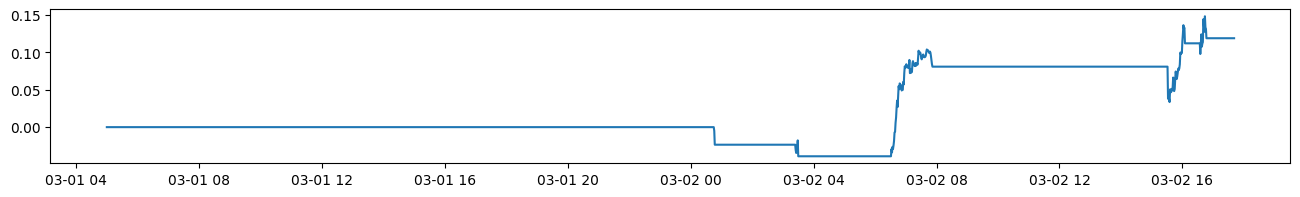

In [236]:
algo.jitter_recovery.research.investigate_trading(dfst_trading)

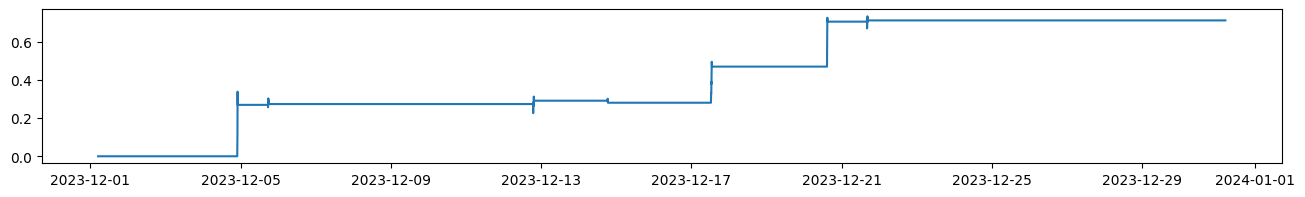

In [263]:
algo.jitter_recovery.research.investigate_trading(dfst_trading)

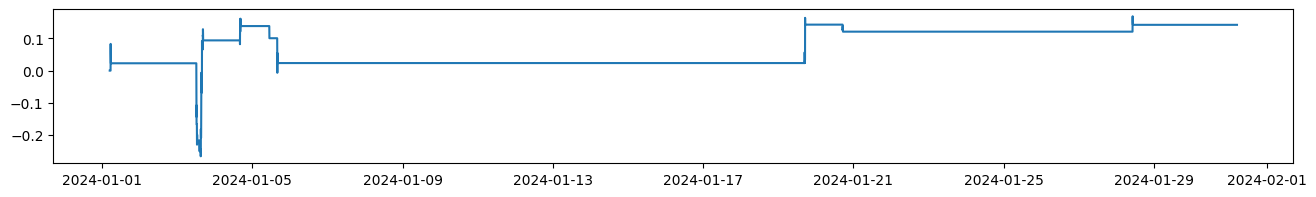

In [17]:
algo.jitter_recovery.research.investigate_trading(dfst_trading)

In [237]:
dfst_trading[dfst_trading.profit.fillna(0) != 0][['profit']].groupby('symbol').sum().sort_values('profit')

,profit
symbol,
SHIB-USDT-SWAP,-0.023490
TURBO-USDT-SWAP,-0.015470
STARL-USDT-SWAP,0.006806
XCH-USDT-SWAP,0.031211
BADGER-USDT-SWAP,0.119840


In [1]:
#dfst_feature.xs('FITFI-USDT-SWAP').loc['2023-12-07 16:38:00']

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < -0.01)]

In [ ]:
dfst_trading[(dfst_trading.ch_max > 0.15) & (dfst_trading.ch_since_max < 0)].loc[symbol_with_jumps[0]]

In [221]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-02-03 18:13:00, GAL-USDT-SWAP, 1.905, position_changed: 1.0
2024-02-03 19:18:00, GAL-USDT-SWAP, 1.852, position_changed: -1.0
2024-02-04 00:19:00, FITFI-USDT-SWAP, 0.006064, position_changed: 1.0
2024-02-04 00:31:00, FITFI-USDT-SWAP, 0.005904, position_changed: -1.0
2024-02-04 20:20:00, DMAIL-USDT-SWAP, 0.4964, position_changed: 1.0
2024-02-04 20:23:00, DMAIL-USDT-SWAP, 0.5023, position_changed: -1.0
2024-02-04 20:24:00, DMAIL-USDT-SWAP, 0.4965, position_changed: 1.0
2024-02-04 20:55:00, DMAIL-USDT-SWAP, 0.4923, position_changed: -1.0


## single symobl

In [200]:
import algo.jitter_recovery.calculate
importlib.reload(algo.jitter_recovery.calculate)
import algo.jitter_recovery.research
importlib.reload(algo.jitter_recovery.research)

<module 'algo.jitter_recovery.research' from '/home/junlim/projects/jitter_recovery/algo/jitter_recovery/research.py'>

In [224]:
symbol_investigate = 'BADGER-USDT-SWAP'
dfs = dfi.xs(symbol_investigate, level=1)

In [250]:
jitter_recovery_trading_param = algo.jitter_recovery.calculate.JitterRecoveryTradingParam(
    algo.jitter_recovery.calculate.JitterRecoveryFeatureParam(30), 
    0.20, -0.04, 0.02, is_long_term=False)

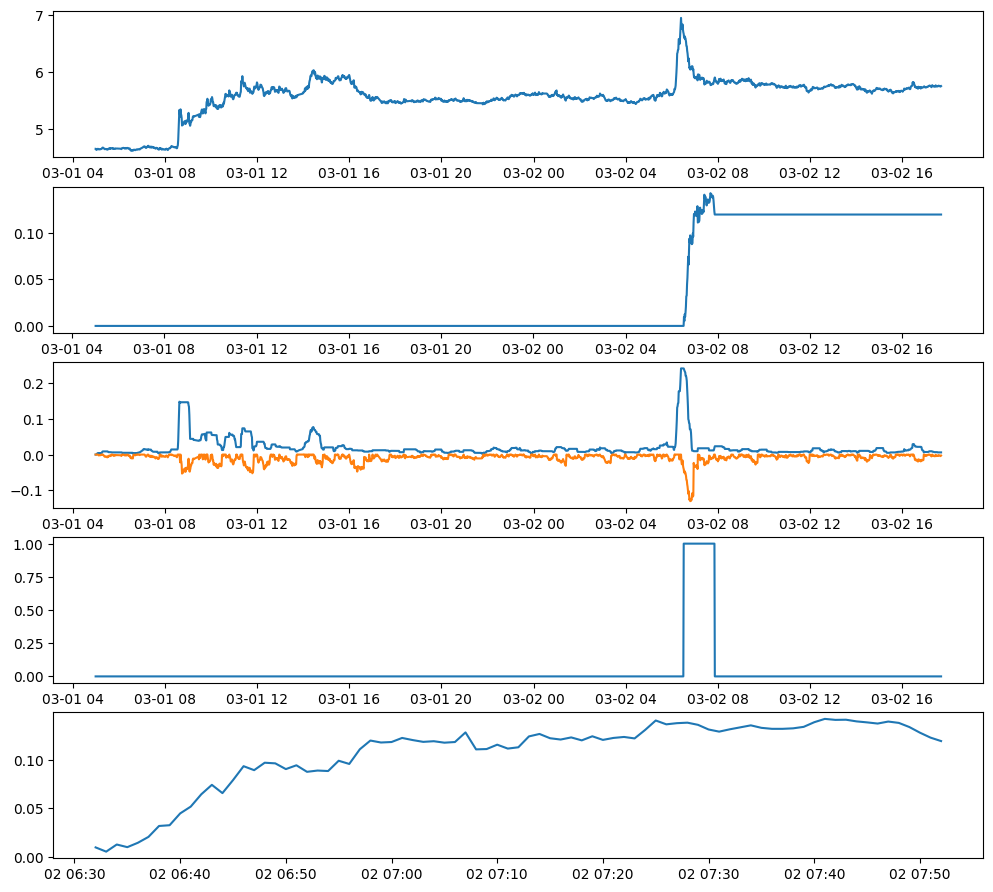

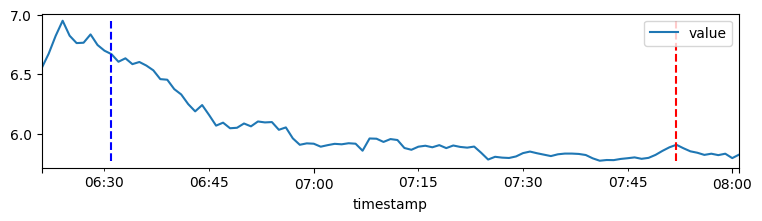

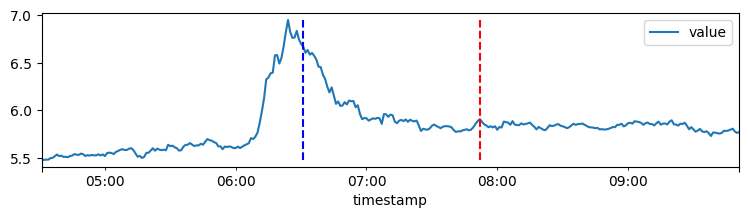

In [251]:
df_feature, df_trading = algo.jitter_recovery.research.investigate_symbol(df, symbol_investigate, jitter_recovery_trading_param, figsize=(12, 11))

In [146]:
df_trading[(df_trading.position_changed != 0)][['value', 'in_position', 'position_changed', 'profit_raw', 'profit']].dropna()

,value,in_position,position_changed,profit_raw,profit
timestamp,,,,,
2024-01-03 12:27:00,1.7395,1,1.0,0.000,0.000000
2024-01-03 12:29:00,1.8060,0,-1.0,-0.016,-0.008939


In [147]:
for _, row in dfst_trading[(dfst_trading.position_changed != 0)].dropna().reset_index().sort_values('timestamp').iterrows():
    if row['symbol'] != symbol_investigate: continue
    print(f'{row["timestamp"]}, {row["symbol"]}, {row["value"]}, position_changed: {row["position_changed"]}')

2024-01-03 12:27:00, ARB-USDT-SWAP, 1.7395, position_changed: 1.0
2024-01-03 12:28:00, ARB-USDT-SWAP, 1.79, position_changed: -1.0
